# Bayesian estimation of photosynthetic parameters in Farquhar-von Caemmerer-Berry model

This note book illustrates how to run Bayesian statistics for parameter estimation of Farquhar-von Caemmerer-Berry (FvCB) model. Bayesian statistics estimate posterior distribution of parameters based on input observations and prior information.  
1) **Input data** needed is CO2 response curves of concurrent net photosynthesis (An) and chlorophyll fluorescence (Y(II)) measurements under several light levels  
2) **Model** used is FvCB model for C3 leaf photosynthesis. An and Y(II) are function of Ci, I, Vm, Km, J, Gstar, Rd, and s.  
<img src="./FvCBmodel.png" alt="Drawing" style="width: 350px;"/>
  
  
3) Noninformative uniform distribution is used as **prior** for each parameter to estimate  
  
  
Joint posterior distribution of the parameters to estimate is then calculated with a software called JAGS (Just Another Gibbs Sampler). With the joint posterior distribution, we also show the marginal distribution of each parameters and esembles of An-Ci and/or Y(II)-Ci curves predicted based on the posterior distribution of estimated parameters. 
  
  
<img src="./pipeline.png" alt="Drawing" style="width: 600px;"/>

# Step 0. Load library

In [1]:
source('FunJAGSFvCB.R')
if (!require("coda")) {
    install.packages("coda")
    library(coda)
}
if (!require("R2jags")) {
    install.packages("R2jags")
    library(R2jags)
}
if (!require("lattice")) {
    install.packages("lattice")
    library(lattice)
}
if (!require("viridis")) {
    install.packages("viridis")
    library(viridis)
}
if (!require("MASS")) {
    install.packages("MASS")
    library(MASS)
}
library(RColorBrewer)

Loading required package: coda
Loading required package: R2jags
Loading required package: rjags
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs

Attaching package: 'R2jags'

The following object is masked from 'package:coda':

    traceplot

Loading required package: lattice
Loading required package: viridis
Loading required package: viridisLite
Loading required package: MASS


# Step 1. Data preparation

## 1.1 Load data

In [2]:
#* Input file path *#
filepath <- "./expdata0827.csv"

In [3]:
# load csv file of input data
numRep <- 5 # number of replications
FLAGyii <- TRUE # to dev: compatible with different obs data
tmpobsall <- read.csv(file = filepath, header = FALSE, sep=',')
obsall <- tmpobsall[,2:length(tmpobsall)]
tmpinterval <- ifelse(FLAGyii, 4, 3)
tmpIDX4Ci <- seq(1, by = tmpinterval, length.out = numRep)
tmpIDX4Q <- seq(2, by = tmpinterval, length.out = numRep)
tmpIDX4A <- seq(3, by = tmpinterval, length.out = numRep)
if (FLAGyii == TRUE) {
    tmpIDX4yii <- seq(4, by = tmpinterval, length.out = numRep)
}
obs.Ci <- obsall[tmpIDX4Ci, ]
obs.Q <- obsall[tmpIDX4Q, ]#to dev: a test for Q
obs.A <- obsall[tmpIDX4A, ]
obs.yii <- obsall[tmpIDX4yii, ]
# Output detected light levels in data
PPFDdetected <- unique(na.omit(unlist(obs.Q)))
cat(paste0("Detect ", length(PPFDdetected)," light levels.\n"))
for (tmploop in seq(length(PPFDdetected))) {
    cat(paste0("J[", tmploop,"] = ",PPFDdetected[tmploop],"\n"))
}

Detect 4 light levels.
J[1] = 2000
J[2] = 300
J[3] = 200
J[4] = 100


## 1.2 Raw data illustration

### 1.2.1 Plot all replications

In [4]:
#* If only one replication, skip this *#

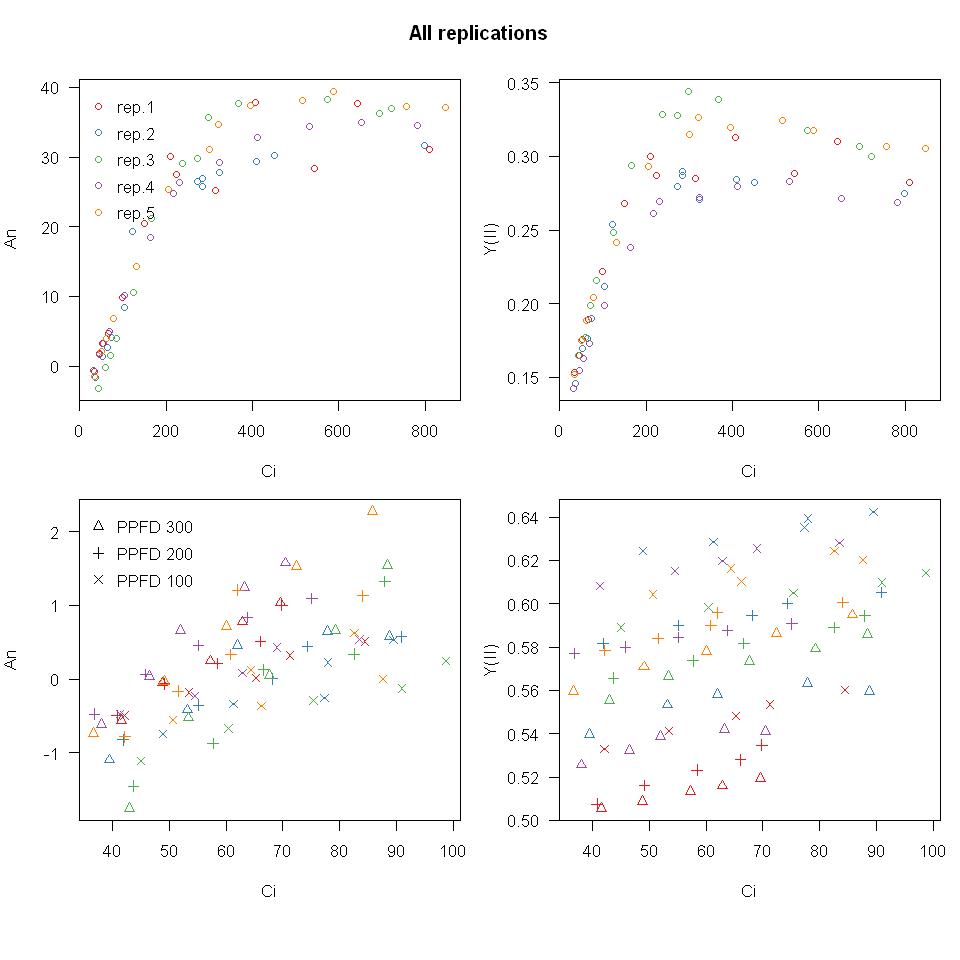

In [5]:
if (numRep!=1) {
## plot all replications together
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(2,2))
cmap1 <- brewer.pal(numRep,"Set1")
#A-Ci under saturating light
par(mar=c(4,4,4,1))
tmpxrange <- range(unlist(obs.Ci)[which(obs.Q==max(PPFDdetected))]) 
tmpyrange <- range(unlist(obs.A)[which(obs.Q==max(PPFDdetected))])
for (looprep2plot in seq(5)) {
    selrep2plot=looprep2plot
    tmpCi=na.omit(unlist(obs.Ci[selrep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(obs.Q[selrep2plot,]))
    tmpA=na.omit(unlist(obs.A[selrep2plot,]))
    tmpyii=na.omit(unlist(obs.yii[selrep2plot,]))
    tmpidx1=which(tmpQ==max(PPFDdetected))
    if (looprep2plot==1) {
        plot(tmpCi[tmpidx1], tmpA[tmpidx1], xlab="Ci", ylab="An",pch=1,
             xlim=tmpxrange, ylim=tmpyrange, col=cmap1[looprep2plot],las=1)
    } else {
        points(tmpCi[tmpidx1], tmpA[tmpidx1], xlab="Ci", ylab="An",pch=1,
               col=cmap1[looprep2plot],las=1)
    }
}
legend("topleft",legend = paste("rep.", seq(numRep), sep=""), 
       col=c(cmap1), bty="n", pch=1,
       y.intersp=1, yjust=1)
#Y(II)-Ci under saturating light
par(mar=c(4,4,4,1))
tmpxrange <- range(unlist(obs.Ci)[which(obs.Q==max(PPFDdetected))]) 
tmpyrange <- range(unlist(obs.yii)[which(obs.Q==max(PPFDdetected))])
for (looprep2plot in seq(5)) {
    selrep2plot=looprep2plot
    tmpCi=na.omit(unlist(obs.Ci[selrep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(obs.Q[selrep2plot,]))
    tmpA=na.omit(unlist(obs.A[selrep2plot,]))
    tmpyii=na.omit(unlist(obs.yii[selrep2plot,]))
    tmpidx1=which(tmpQ==max(PPFDdetected))
    if (looprep2plot==1) {
        plot(tmpCi[tmpidx1], tmpyii[tmpidx1], xlab="Ci", ylab="Y(II)",pch=1,
             xlim=tmpxrange, ylim=tmpyrange, col=cmap1[looprep2plot],las=1)
    } else {
        points(tmpCi[tmpidx1], tmpyii[tmpidx1], xlab="Ci", ylab="Y(II)",pch=1,
               col=cmap1[looprep2plot],las=1)
    }
}
#A-Ci under low light
par(mar=c(7,4,1,1))
tmpxrange <- range(unlist(obs.Ci)[which(obs.Q!=max(PPFDdetected))])#NA will not be included
tmpyrange <- range(unlist(obs.A)[which(obs.Q!=max(PPFDdetected))])
for (looprep2plot in seq(5)) {
    selrep2plot=looprep2plot
    tmpCi=na.omit(unlist(obs.Ci[selrep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(obs.Q[selrep2plot,]))
    tmpA=na.omit(unlist(obs.A[selrep2plot,]))
    tmpyii=na.omit(unlist(obs.yii[selrep2plot,]))
    tmpidx2=which(tmpQ!=max(PPFDdetected))
    for (tmploop in seq(length(PPFDdetected)-1)) {
        tmplowlight=PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))[tmploop]]
        tmpidx2=which(tmpQ==tmplowlight)
        if (looprep2plot==1 && tmploop==1) {
            plot(tmpCi[tmpidx2], tmpA[tmpidx2], xlab="Ci", ylab="An",pch=tmploop+1,
                 xlim=tmpxrange, ylim=tmpyrange, col=cmap1[looprep2plot],las=1)
        } else {
            points(tmpCi[tmpidx2], tmpA[tmpidx2], xlab="Ci", ylab="An",pch=tmploop+1,
                   col=cmap1[looprep2plot],las=1)
        }
    }
}
legend("topleft",legend = paste("PPFD ", PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))],sep=""), 
       bty="n", pch=seq(2,length(PPFDdetected)),
       y.intersp=1, yjust=1)
#Y(II)-Ci under low light
par(mar=c(7,4,1,1))
tmpxrange <- range(unlist(obs.Ci)[which(obs.Q!=max(PPFDdetected))])#NA will not be included
tmpyrange <- range(unlist(obs.yii)[which(obs.Q!=max(PPFDdetected))])
for (looprep2plot in seq(5)) {
    selrep2plot=looprep2plot
    tmpCi=na.omit(unlist(obs.Ci[selrep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(obs.Q[selrep2plot,]))
    tmpA=na.omit(unlist(obs.A[selrep2plot,]))
    tmpyii=na.omit(unlist(obs.yii[selrep2plot,]))
    tmpidx2=which(tmpQ!=max(PPFDdetected))
    for (tmploop in seq(length(PPFDdetected)-1)) {
        tmplowlight=PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))[tmploop]]
        tmpidx2=which(tmpQ==tmplowlight)
        if (looprep2plot==1 && tmploop==1) {
            plot(tmpCi[tmpidx2], tmpyii[tmpidx2], xlab="Ci", ylab="Y(II)",pch=tmploop+1,
                 xlim=tmpxrange, ylim=tmpyrange, col=cmap1[looprep2plot],las=1)
        } else {
            points(tmpCi[tmpidx2], tmpyii[tmpidx2], xlab="Ci", ylab="Y(II)",pch=tmploop+1,
                   col=cmap1[looprep2plot],las=1)
        }
    }
}
title("All replications", outer=TRUE, line=-2)
}

### 1.2.2 Plot each replication

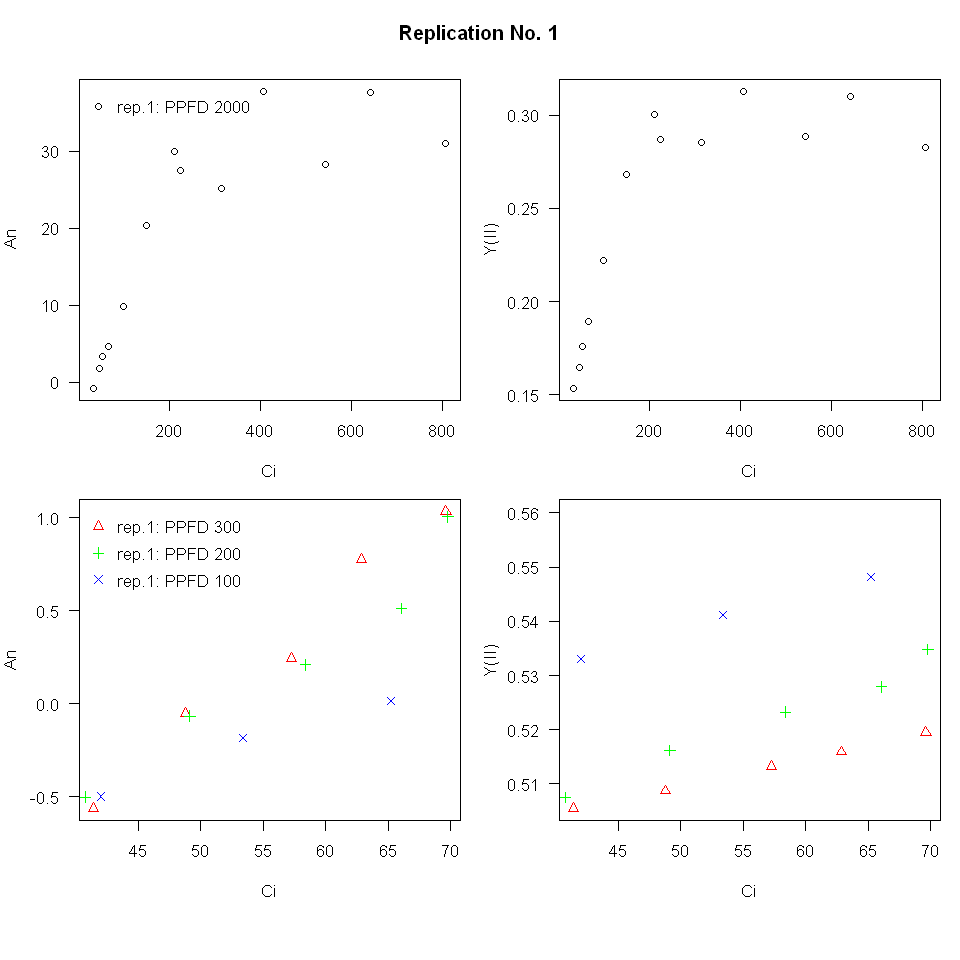

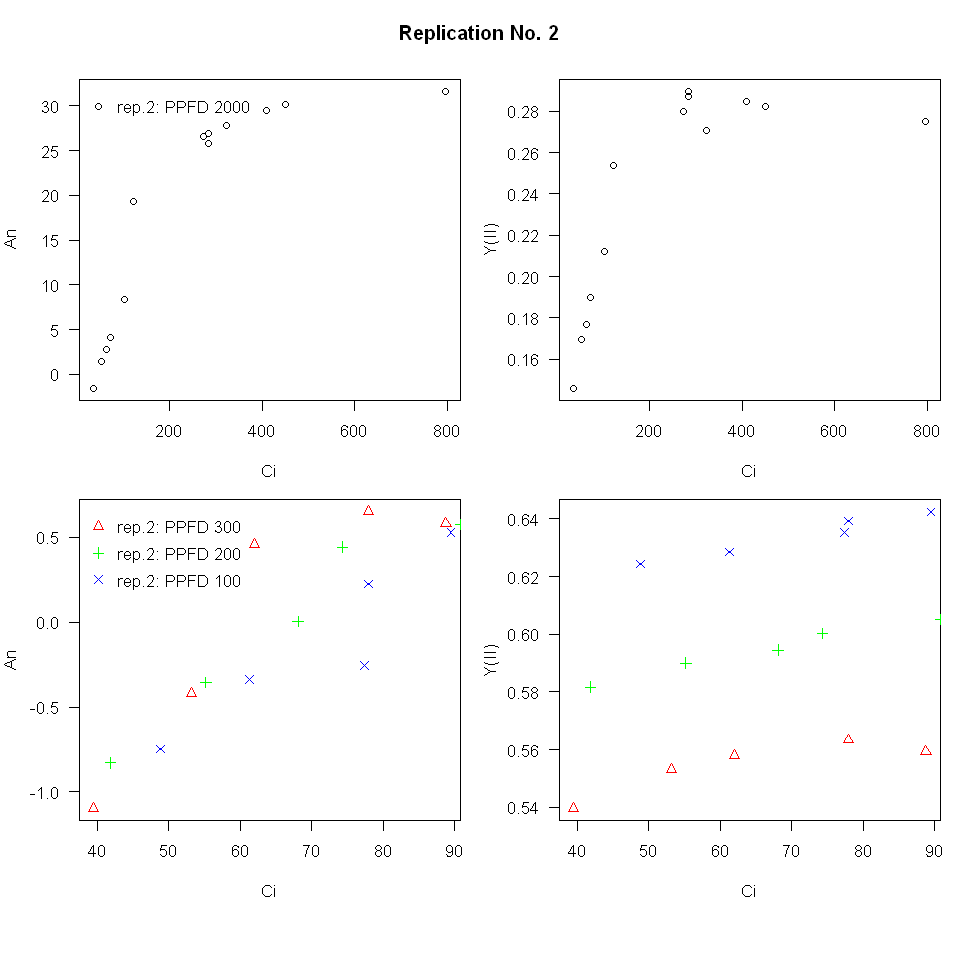

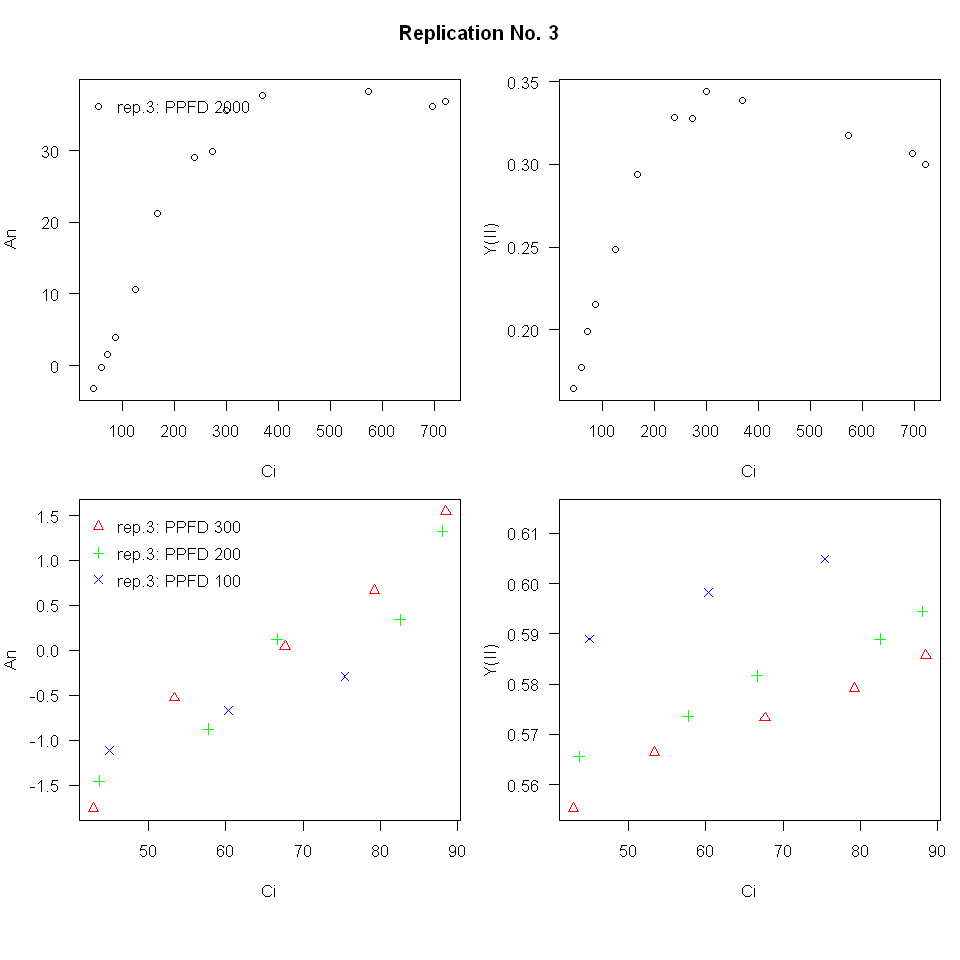

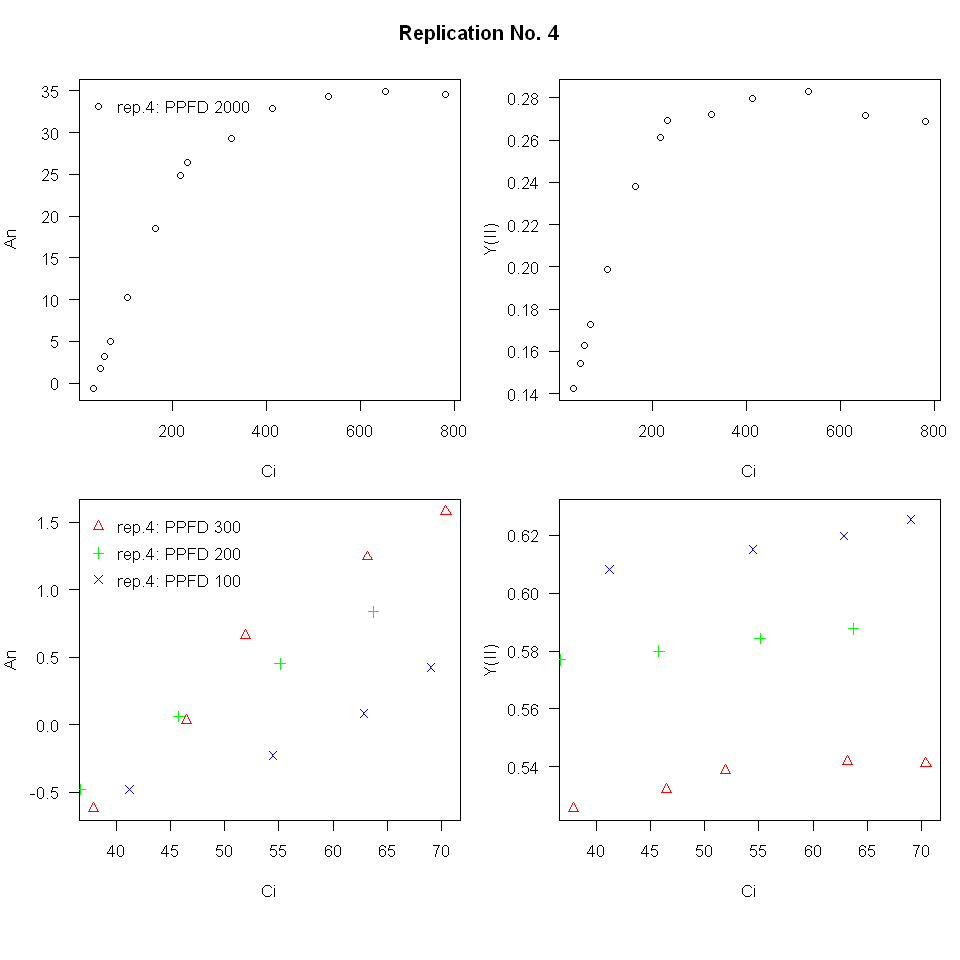

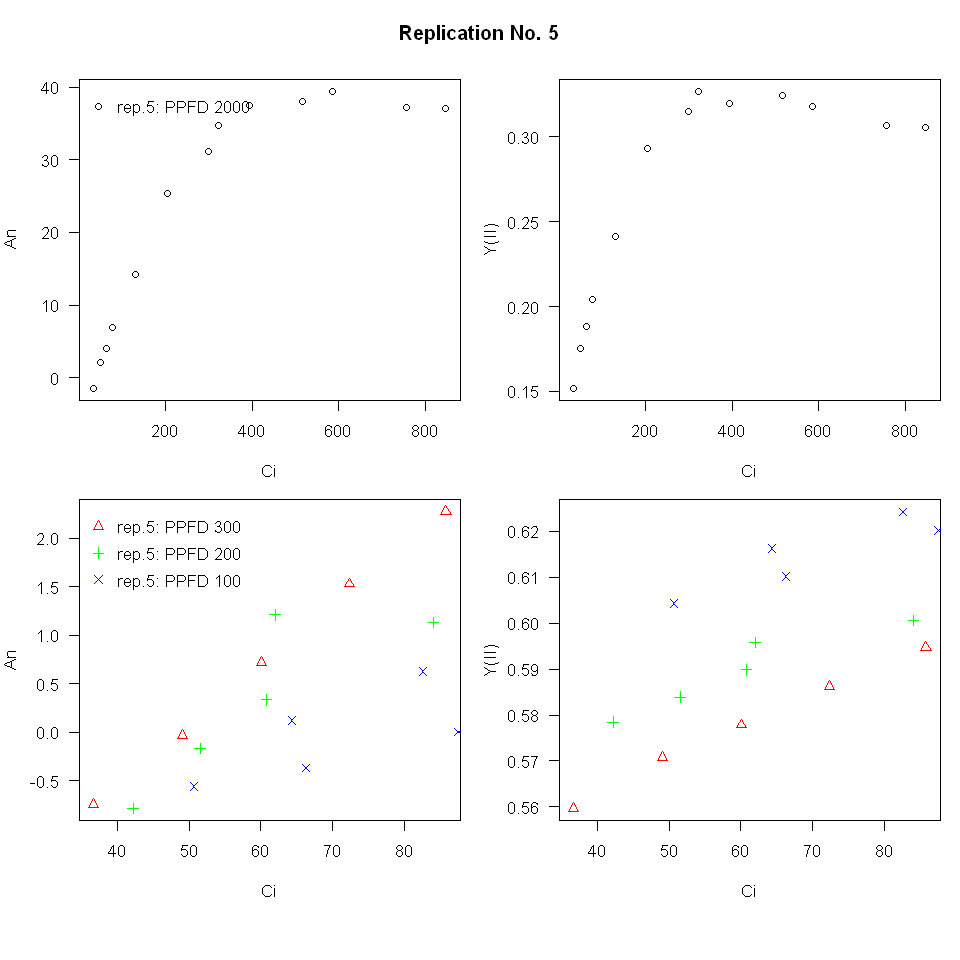

In [6]:
## plot each replication
for (looprep2plot in seq(numRep)) {
    selrep2plot=looprep2plot
    options(repr.plot.width = 8, repr.plot.height = 8)
    par(mfrow=c(2,2))
    tmpCi=na.omit(unlist(obs.Ci[selrep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(obs.Q[selrep2plot,]))
    tmpA=na.omit(unlist(obs.A[selrep2plot,]))
    tmpyii=na.omit(unlist(obs.yii[selrep2plot,]))
    # identify data under saturating irradiance and plot
    par(mar=c(4,4,4,1))
    tmpidx1=which(tmpQ==max(PPFDdetected))
    plot(tmpCi[tmpidx1],tmpA[tmpidx1],xlab="Ci",ylab="An",las=1)
    legend('topleft', legend = paste("rep.", selrep2plot, ": PPFD ",max(PPFDdetected), sep=""), 
           col="black", bty="n", box.lty=0, pch=1, yjust=1)
    par(mar=c(4,4,4,1))
    plot(tmpCi[tmpidx1],tmpyii[tmpidx1],xlab="Ci",ylab="Y(II)",las=1)
    # identify data under low light and plot
    par(mar=c(7,4,1,1))
    idxlowlights=which(tmpQ!=max(PPFDdetected))
    cmap2 <- rainbow(length(PPFDdetected)-1)
    for (tmploop in seq(length(PPFDdetected)-1)) {
        tmplowlight=PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))[tmploop]]
        tmpidx2=which(tmpQ==tmplowlight)
        if (tmploop==1) {
            plot(tmpCi[tmpidx2], tmpA[tmpidx2], xlab="Ci", ylab="An",pch=tmploop+1,
                 ylim=range(tmpA[idxlowlights]), col=cmap2[tmploop],las=1)
        } else {
            points(tmpCi[tmpidx2], tmpA[tmpidx2], xlab="Ci", ylab="An",pch=tmploop+1,
                   col=cmap2[tmploop],las=1)
        }
    }
    legend("topleft",legend = paste("rep.", selrep2plot, ": PPFD ",PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))], sep=""), 
           col=c(cmap2), bty="n", box.lty=0, pch=seq(length(PPFDdetected)-1)+1,
           y.intersp=1, yjust=1)
    par(mar=c(7,4,1,1))
    for (tmploop in seq(length(PPFDdetected)-1)) {
        tmplowlight=PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))[tmploop]]
        tmpidx2=which(tmpQ==tmplowlight)
        if (tmploop==1) {
            plot(tmpCi[tmpidx2], tmpyii[tmpidx2], xlab="Ci", ylab="Y(II)",pch=tmploop+1,
                 ylim=range(tmpyii[idxlowlights]), col=cmap2[tmploop],las=1)
        } else {
            points(tmpCi[tmpidx2], tmpyii[tmpidx2], xlab="Ci", ylab="Y(II)",pch=tmploop+1,
                   col=cmap2[tmploop],las=1)
        }
    }
    title(paste("Replication No.",looprep2plot), outer=TRUE, line=-2)
}

# Step 2. Configure Bayesian estimation and run

## 2.1 Configure prefixed parameters

In [7]:
# prefixed Km values during Bayesian estimation
fixedpar <- list(Km=535.3270) #von Caemmerer 2000

## 2.2 Configure JAGS

In [8]:
# Remarks: to develop
#jags.data <- list("Ci", "Aobs", "yiiobs", "numRep", "numPts", 
#                "PPFD", "PPFDidx", "numPPFD",
#                "Km")
#jags.params <- c("Vcmax", "J", "Resp", "Km", "Gstar", "rm",
#                "s", "taoA", "taoyii")
#jags.inits <- function(){
#list("sigA" = 2, 
#        "sigyii" = 0.2,
#        "Vcmax" = 100,
#        "J" = seq(125, by = 0, length.out = numPPFD),
#        "Resp" = 2,
#        "Gstar" = 30,
#        "rm" = 1,
#        "s" = 0.85*0.5)
#}

## 2.3 Run JAGS
Bayesian estimation with data of all replications and each replication.

In [9]:
# run JAGS with each replication as observation of Bayesian estimation
SaveJAGSOneRep <- list()
for (looprep4jags in seq(numRep)) {
    timestart <- Sys.time()
    tmpCi=na.omit(unlist(obs.Ci[looprep4jags,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(obs.Q[looprep4jags,]))
    tmpA=na.omit(unlist(obs.A[looprep4jags,]))
    tmpyii=na.omit(unlist(obs.yii[looprep4jags,]))
    tmpjagsfit.p <- FunJAGSFvCBgm(tmpCi, tmpQ, tmpA, tmpyii, PPFDdetected, fixedpar, JAGS.ini)
    timeend <- Sys.time()
    runningtime <- timeend - timestart
    cat(paste("JAGS with replication No.", looprep4jags, " done: ", runningtime, " secs\n"), sep="")
    SaveJAGSOneRep[[looprep4jags]] <- tmpjagsfit.p
}
# run JAGS with all replications as observation of Bayesian estimation
if (numRep!=1) {
    timestart <- Sys.time()
    tmpCi=na.omit(unlist(obs.Ci))#compatible to replications with different pts
    tmpQ=na.omit(unlist(obs.Q))
    tmpA=na.omit(unlist(obs.A))
    tmpyii=na.omit(unlist(obs.yii))
    SaveJAGSAllReps <- FunJAGSFvCBgm(tmpCi, tmpQ, tmpA, tmpyii, PPFDdetected, fixedpar, JAGS.ini)
    timeend <- Sys.time()
    runningtime <- timeend - timestart
    cat(paste("JAGS with all replications done: ", runningtime, " secs\n"), sep="")
}

JAGS with replication No. 1  done:  8.90203881263733  secs
JAGS with replication No. 2  done:  8.94735312461853  secs
JAGS with replication No. 3  done:  8.73721694946289  secs
JAGS with replication No. 4  done:  8.79896998405457  secs
JAGS with replication No. 5  done:  8.72473406791687  secs
JAGS with all replications done:  47.2100410461426  secs


## 2.4 Check convergence

In [10]:
# Print summary of JAGS results
# mean value, standard deviation and different quantiles are shown
# Any Rhat>1.1 means Bayesian estimation is not converged yet

if (numRep!=1) {
    cat("***********************************************\n")
    cat(paste("Summary of JAGS with all replications\n"))
    cat("***********************************************\n")
    print(SaveJAGSAllReps)
    cat("\n\n\n\n")
}
for (looprep4jags in seq(numRep)) {
    cat("***********************************************\n")
    cat(paste("Summary of JAGS with replication No.", looprep4jags, "\n"))
    cat("***********************************************\n")
    print(SaveJAGSOneRep[[looprep4jags]])
    cat("\n\n\n\n")
}

***********************************************
Summary of JAGS with all replications
***********************************************
Inference for Bugs model at "fvcb_ayii_ciLL_gm_fixKm_vR.txt", fit using jags,
 3 chains, each with 20000 iterations (first 10000 discarded)
 n.sims = 30000 iterations saved
          mu.vect sd.vect     2.5%      25%      50%      75%    97.5%  Rhat
Gstar      34.056   2.717   28.252   32.335   34.232   35.940   39.005 1.008
J[1]      176.043   2.681  170.844  174.235  176.022  177.839  181.358 1.003
J[2]       48.715   1.144   46.503   47.949   48.685   49.492   50.968 1.004
J[3]       33.891   0.788   32.370   33.356   33.877   34.417   35.472 1.004
J[4]       17.823   0.413   17.026   17.543   17.817   18.100   18.640 1.004
Km        535.327   0.000  535.327  535.327  535.327  535.327  535.327 1.000
Resp        1.640   0.383    0.924    1.376    1.629    1.892    2.440 1.007
Vcmax     123.690   6.428  114.238  119.100  122.548  127.186  139.478 1.015


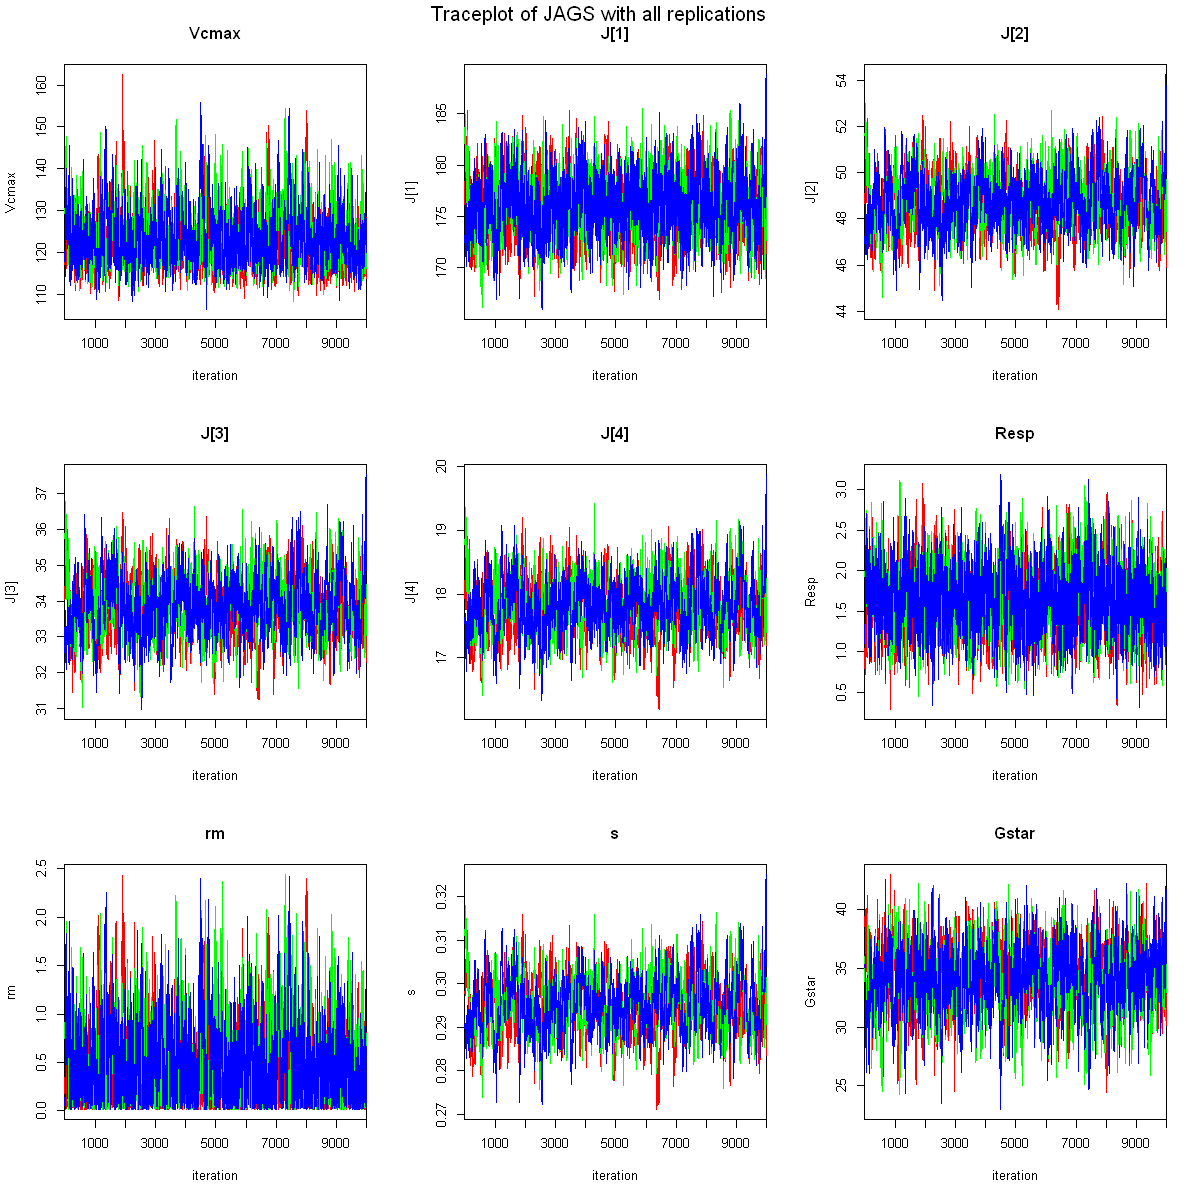

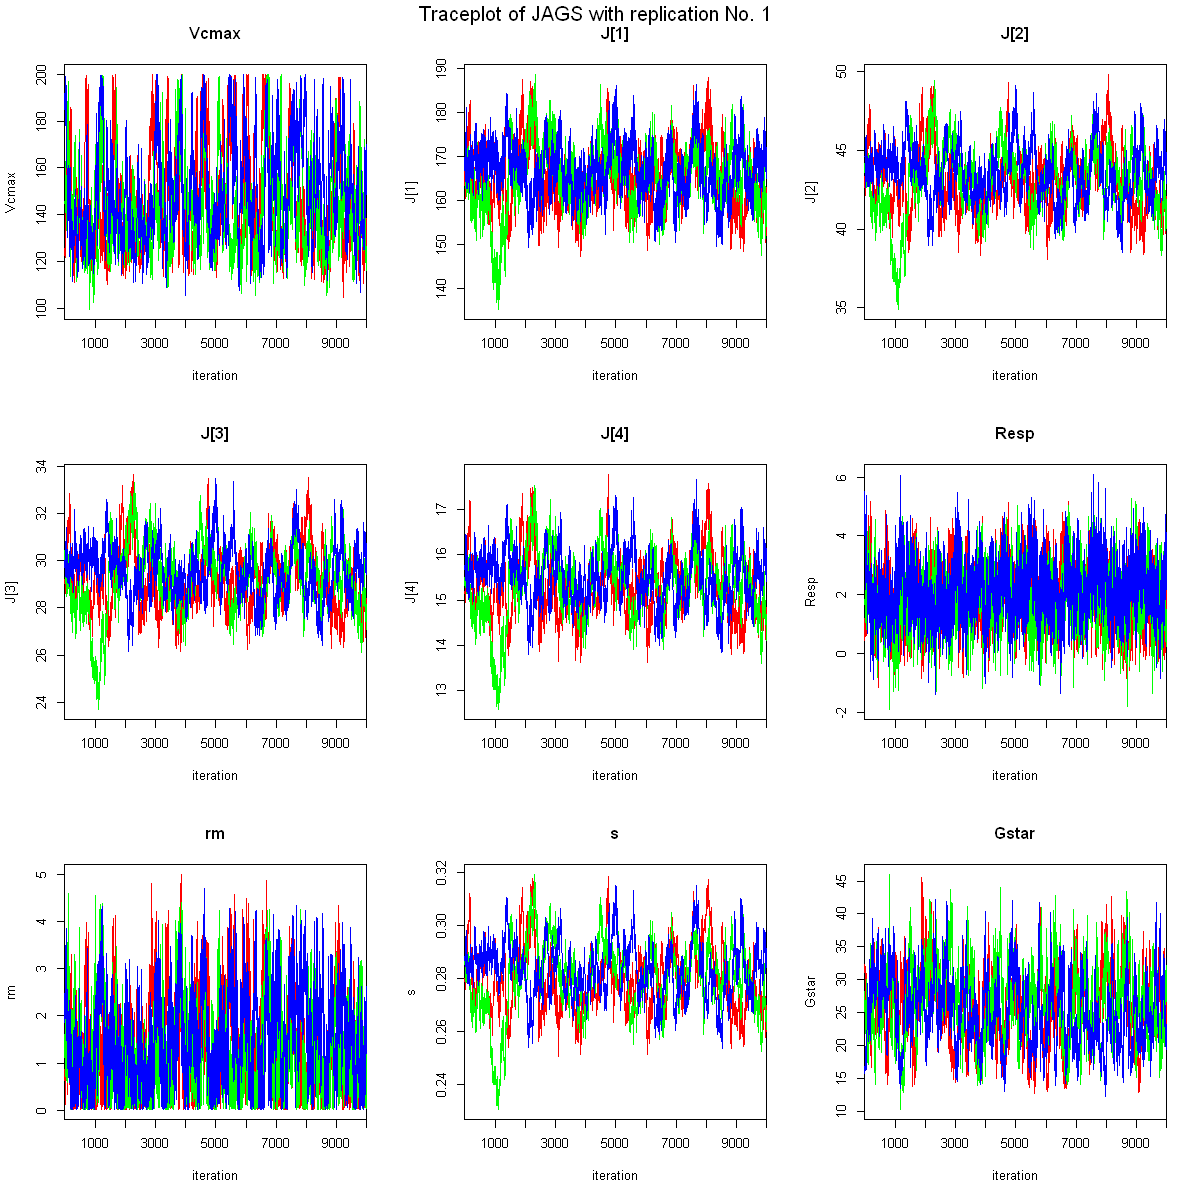

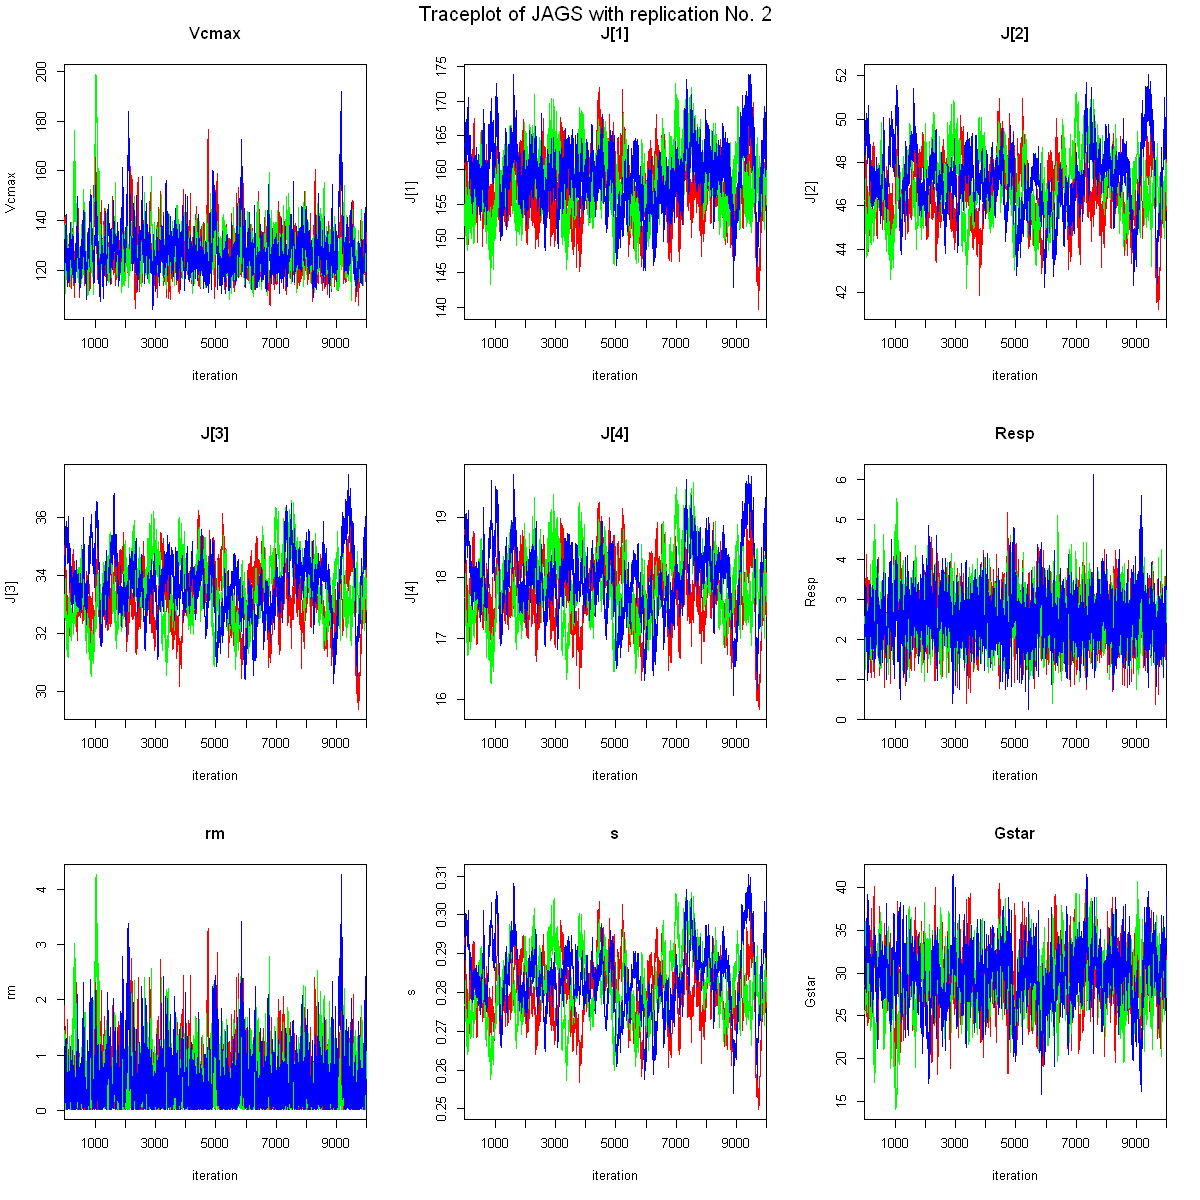

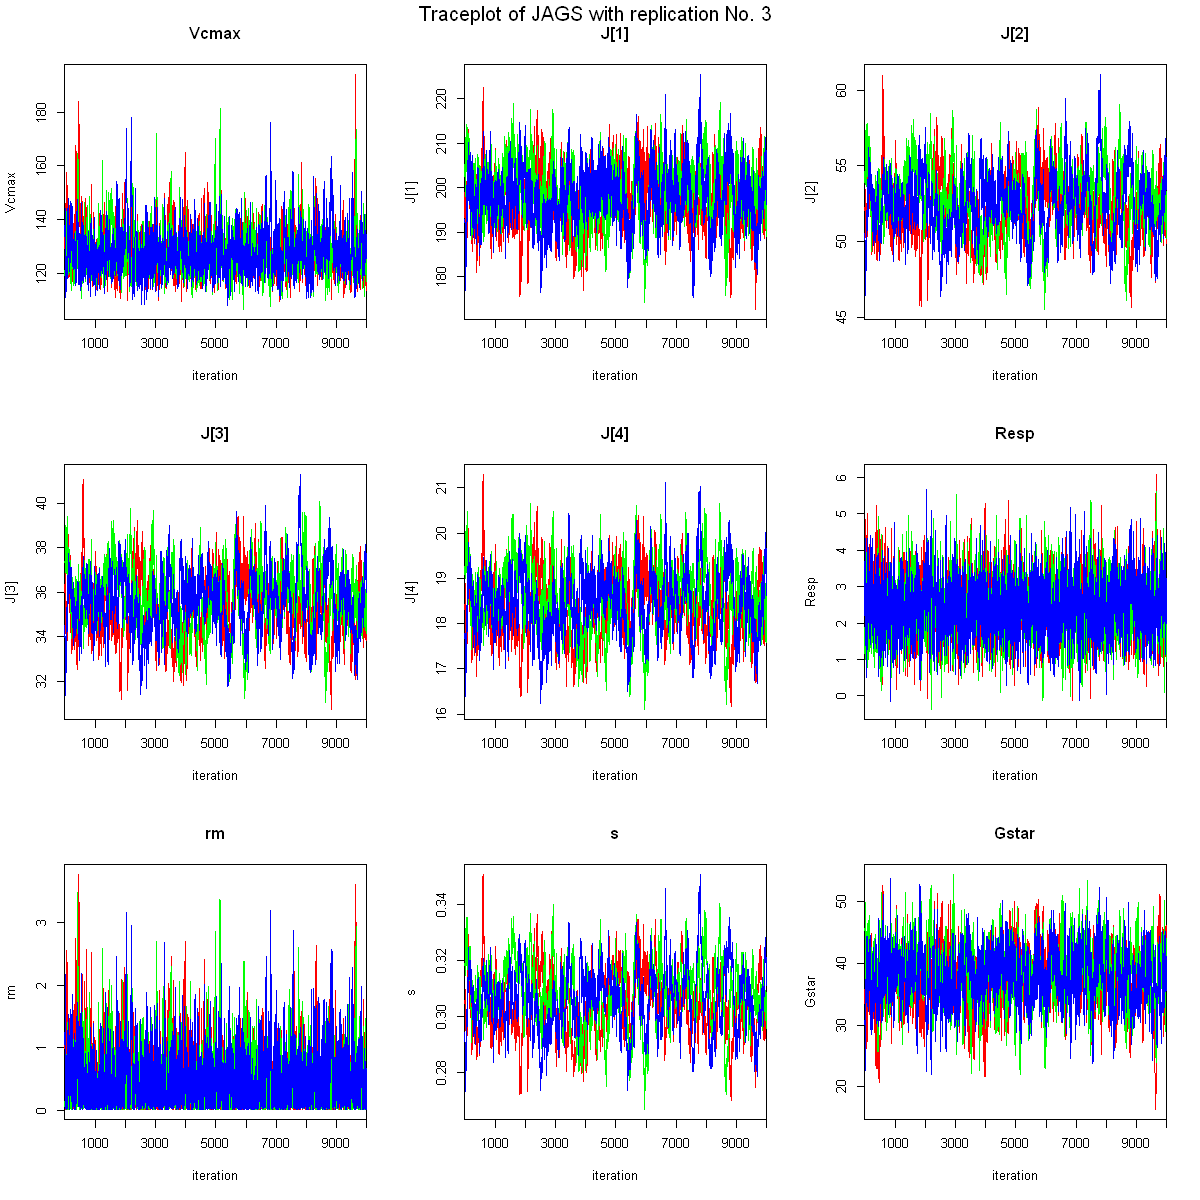

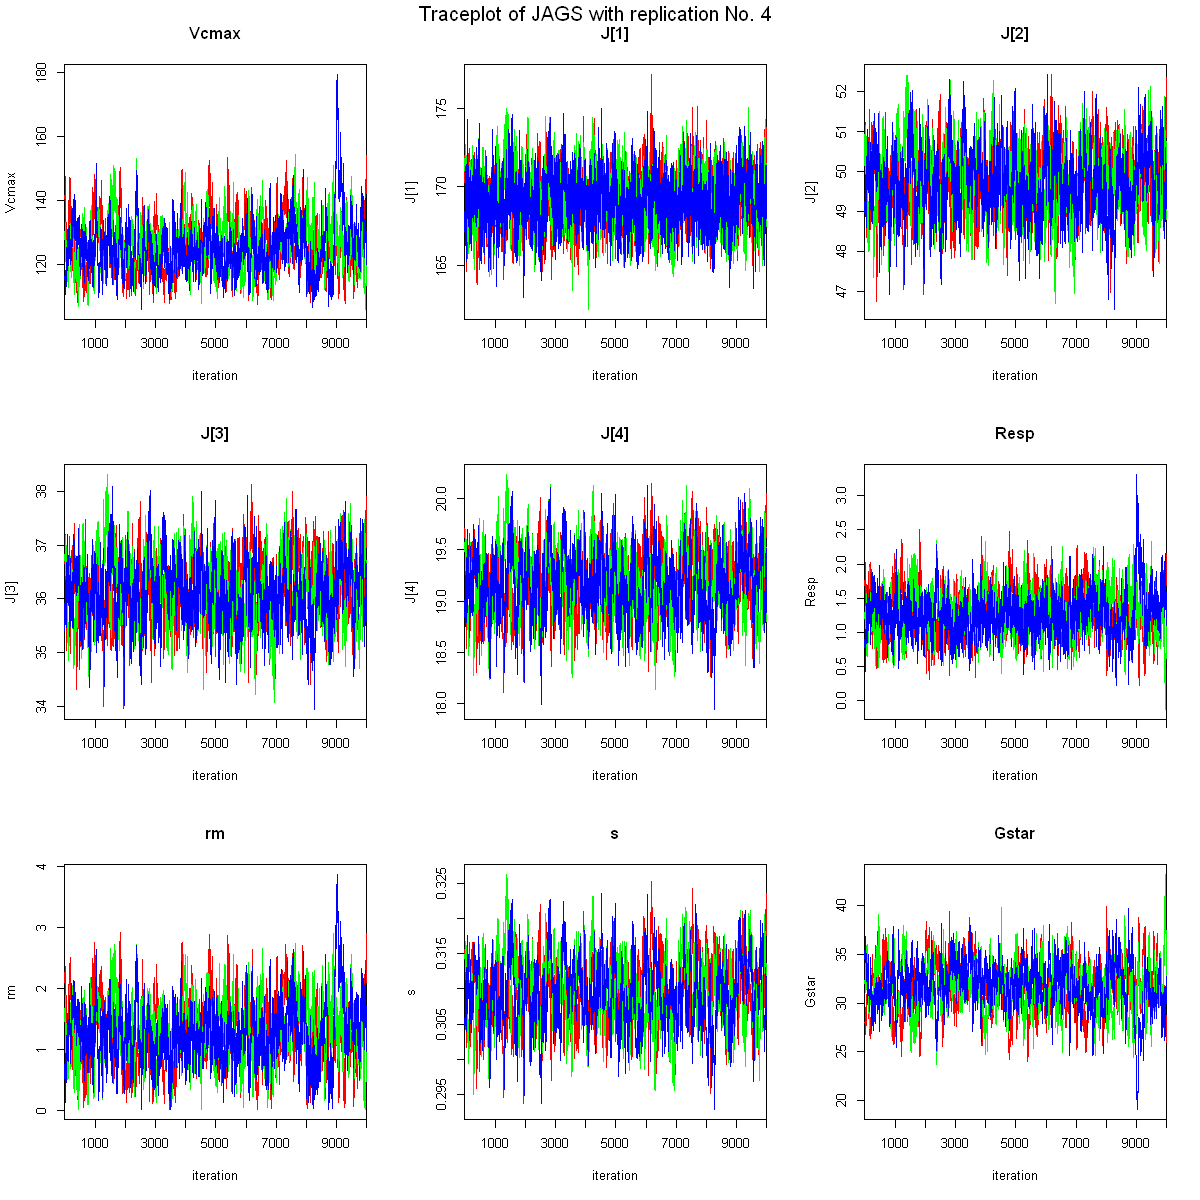

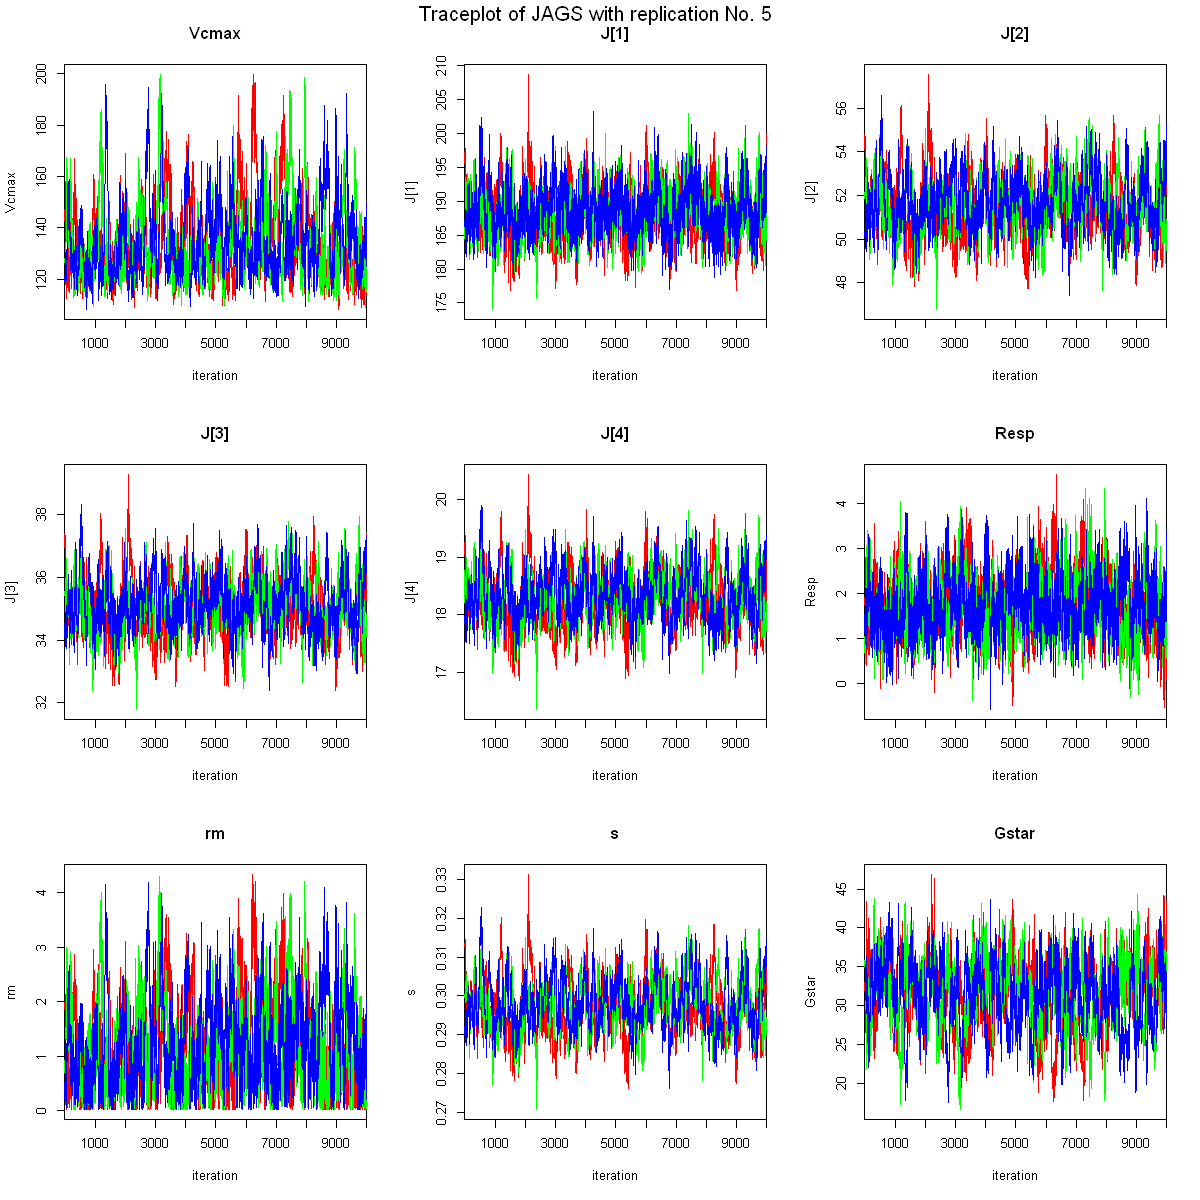

In [11]:
# plot the Monte-Carlo-Markov-Chain of approximated posterior distributions
if (numRep!=1) {
    #plot.new()
    options(repr.plot.width=10, repr.plot.height=10)
    traceplot(SaveJAGSAllReps, mfrow=c(3,3), varname = c('Vcmax','J','Resp','rm','s','Gstar'))
    mtext(paste("Traceplot of JAGS with all replications\n"), side = 3, line = -3, outer=TRUE)
}
for (looprep4jags in seq(numRep)) {
    #plot.new()
    options(repr.plot.width=10, repr.plot.height=10)
    traceplot(SaveJAGSOneRep[[looprep4jags]], mfrow=c(3,3), varname = c('Vcmax','J','Resp','rm','s','Gstar'))
    mtext(paste("Traceplot of JAGS with replication No.", looprep4jags, "\n"), side = 3, line = -3, outer=TRUE)
}

# Step 3. Plot posterior distribution and save results

## 3.1 Plot marginal posterior distribution of each estimated parameter

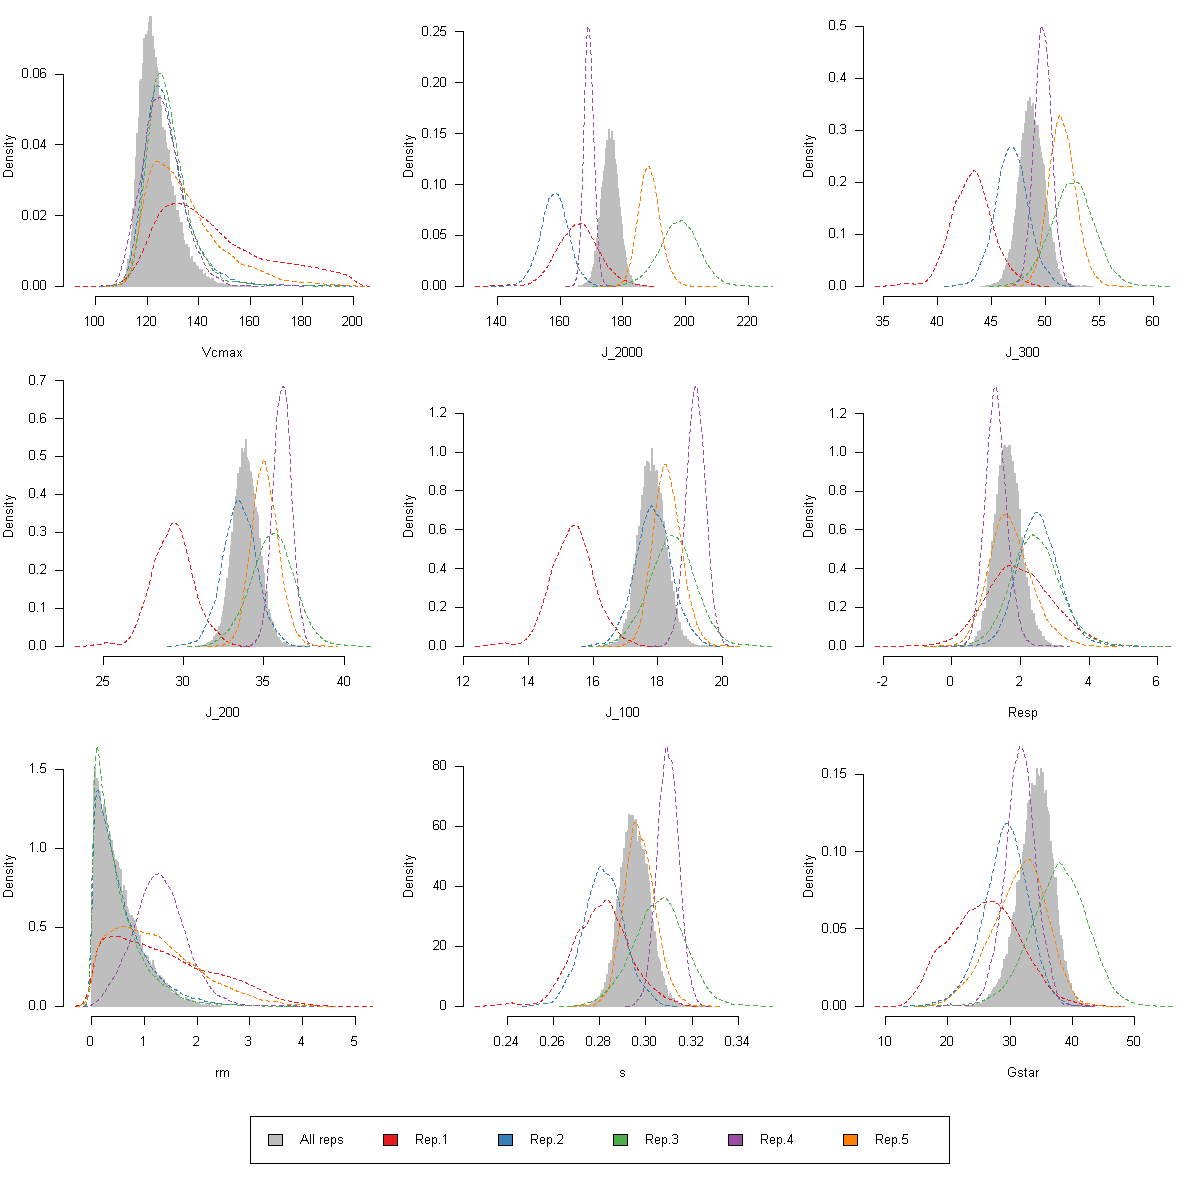

In [12]:
#jagsfit.mcmc <- as.mcmc(jagsfit.p)
#densityplot(jagsfit.mcmc) #xyplot(jagsfit.mcmc) # same as traceplot
cmap3=brewer.pal(numRep,"Set1")
#par(mfrow=c(3,3))
#options(repr.plot.width=10, repr.plot.height=10)
layout(matrix(c(seq(9),rep(10,3)),4,3,byrow = TRUE), rep(3,3), c(rep(3,3),1))

varname2plot <- c('Vcmax','J','Resp','rm','s','Gstar')
for (tmpvar in varname2plot) {
    if (tmpvar != 'J') {
        tmpidx <- which(tmpvar == names(SaveJAGSAllReps$BUGSoutput$sims.list))
        #detect tmpxrange and tmpyrange for plot
        tmpxrange <- range(density(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]]))$x)
        tmpyrange <- range(density(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]]))$y)
        for (looprep4jags in seq(numRep)) {
            tmpxrange2 <- range(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]]))$x)
            tmpyrange2 <- range(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]]))$y)
            #update range
            tmpxrange <- range(c(tmpxrange,tmpxrange2))
            tmpyrange <- range(c(tmpyrange,tmpyrange2))
        }
        #density plot
        par(mar=c(4,4,1,1))
        hist(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]]),
             xlim=tmpxrange, ylim=tmpyrange, col="gray", border="gray",
             breaks=100, main=NULL, xlab=tmpvar, las=1, prob=TRUE)
        for (looprep4jags in seq(numRep)){
            lines(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]])),
                   col=cmap3[looprep4jags], lty=2, main="",xlab=tmpvar,las=1)
        }
        
    }
    else {
        tmpidx <- which(tmpvar == names(SaveJAGSAllReps$BUGSoutput$sims.list))
        for (looplightlevel in seq(ncol(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]]))) {
            #detect tmpxrange and tmpyrange for plot
            tmpxrange <- range(density(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]][,looplightlevel]))$x)
            tmpyrange <- range(density(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]][,looplightlevel]))$y)
            for (looprep4jags in seq(numRep)) {
                tmpxrange2 <- range(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]][,looplightlevel]))$x)
                tmpyrange2 <- range(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]][,looplightlevel]))$y)
                #update range
                tmpxrange <- range(c(tmpxrange,tmpxrange2))
                tmpyrange <- range(c(tmpyrange,tmpyrange2))
            }
            #density plot
            par(mar=c(4,4,1,1))
            hist(as.vector(SaveJAGSAllReps$BUGSoutput$sims.list[[tmpidx]][,looplightlevel]),
                 xlim=tmpxrange, ylim=tmpyrange, col="gray", border="gray", breaks=100, main=NULL, 
                 xlab=paste(tmpvar,"_",PPFDdetected[looplightlevel], sep=""), las=1, prob=TRUE)
            for (looprep4jags in seq(numRep)) {
                lines(density(as.vector(SaveJAGSOneRep[[looprep4jags]]$BUGSoutput$sims.list[[tmpidx]][,looplightlevel])),
                      col=cmap3[looprep4jags], lty=2, main="",xlab=tmpvar,las=1)
            }
        }
    }
}
par(mar=c(0,0,0,0))
plot.new()
legend(x="center", ncol=numRep+1,legend=c("All reps",paste("Rep.",seq(numRep),sep="")),
       fill=c("gray",cmap3))

## 3.2 Plot bivariate posterior distribution

In [13]:
# to complete: select which parameters to plot the bivariate distribution

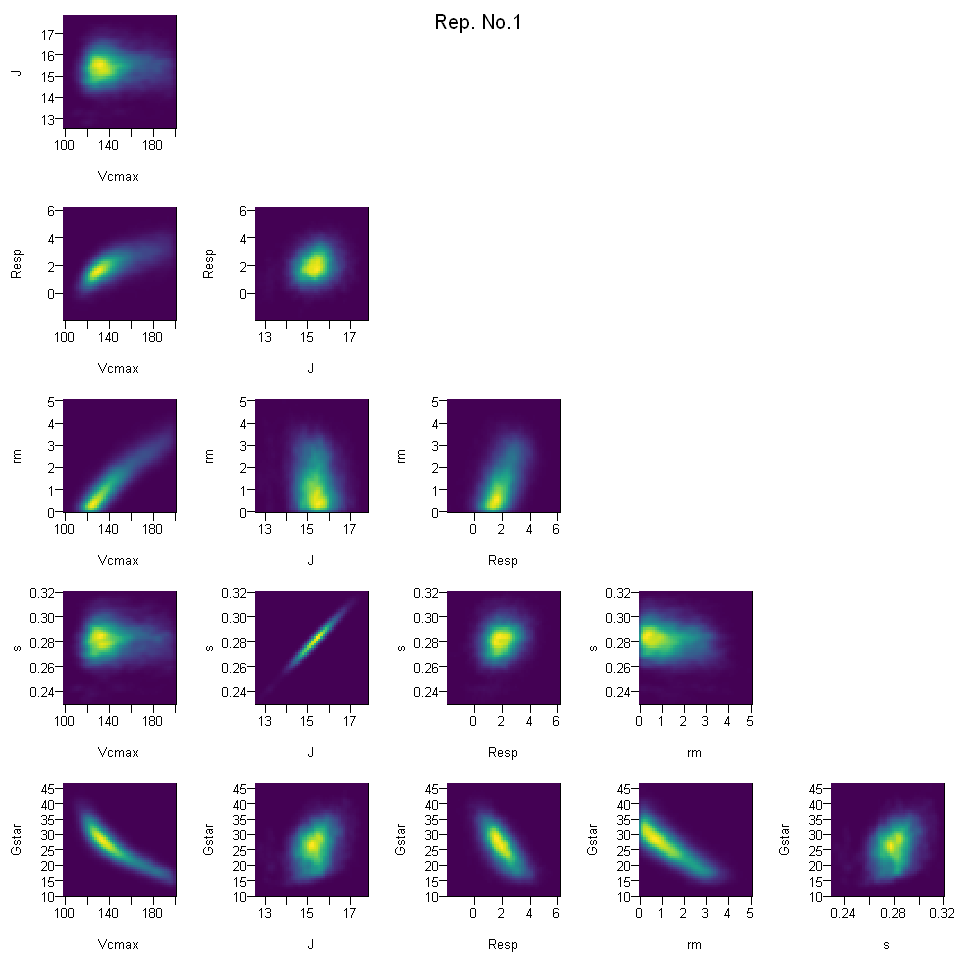

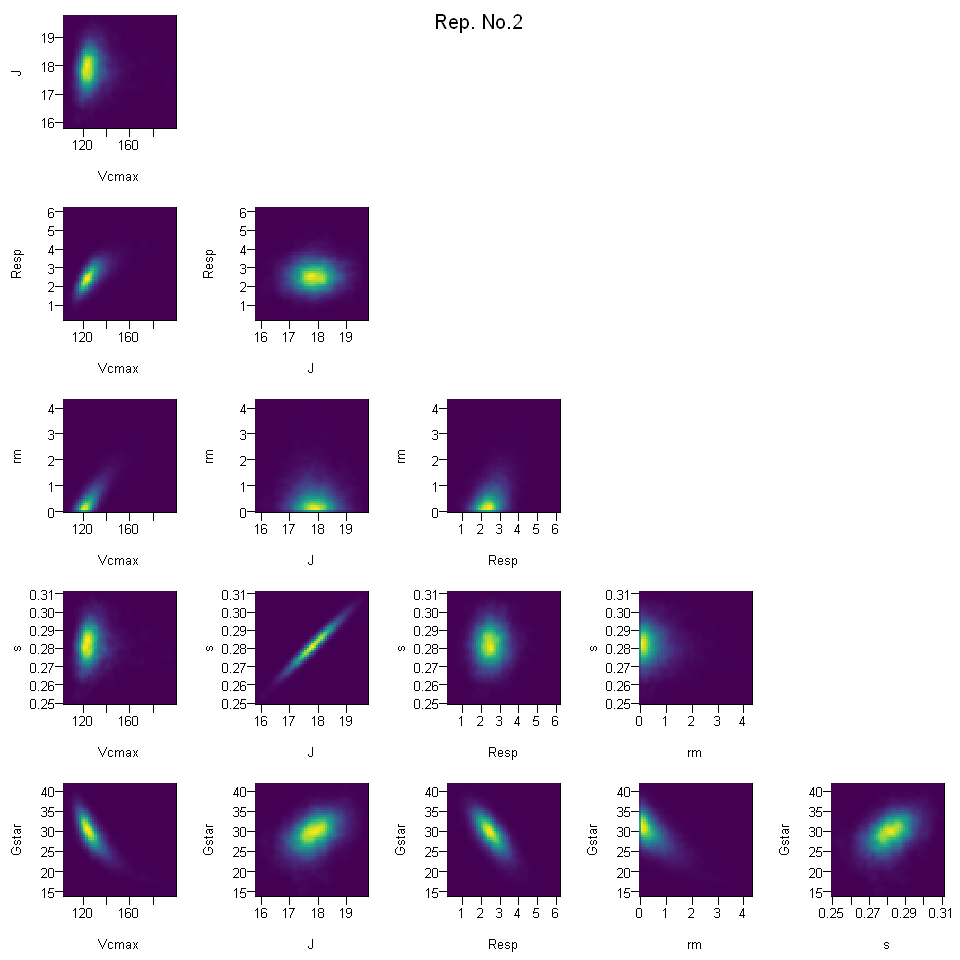

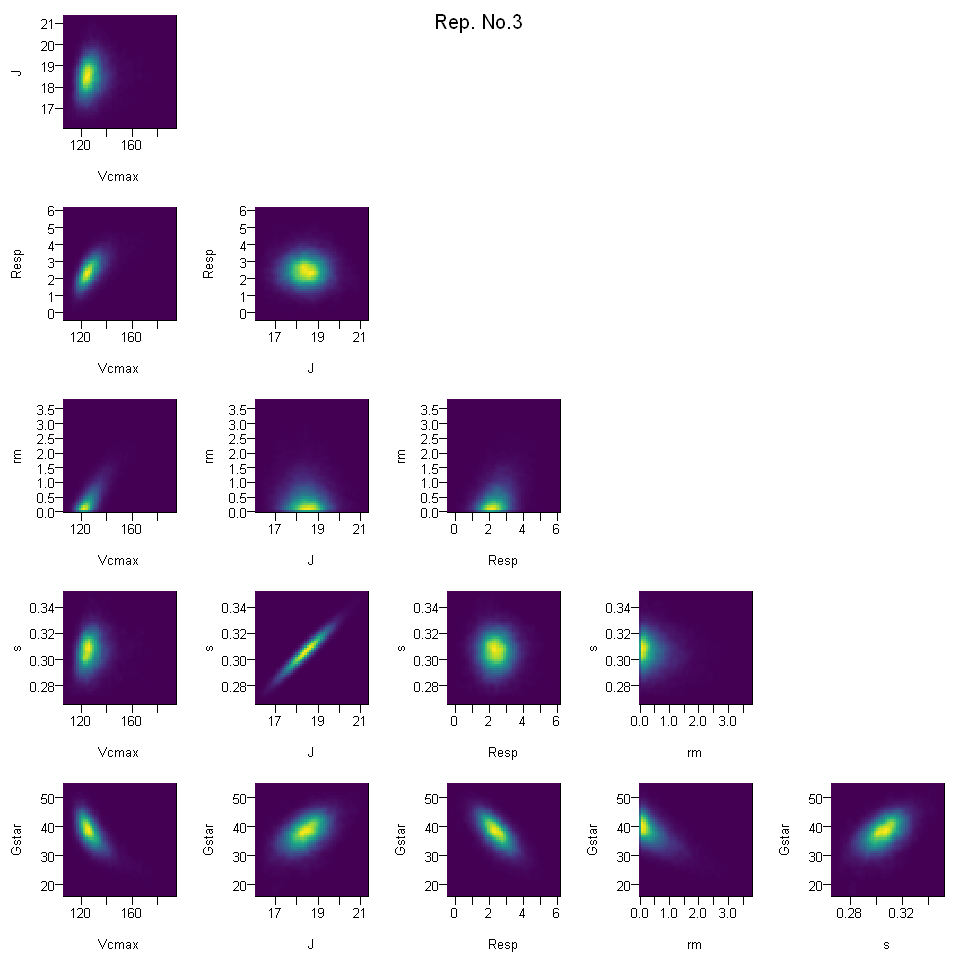

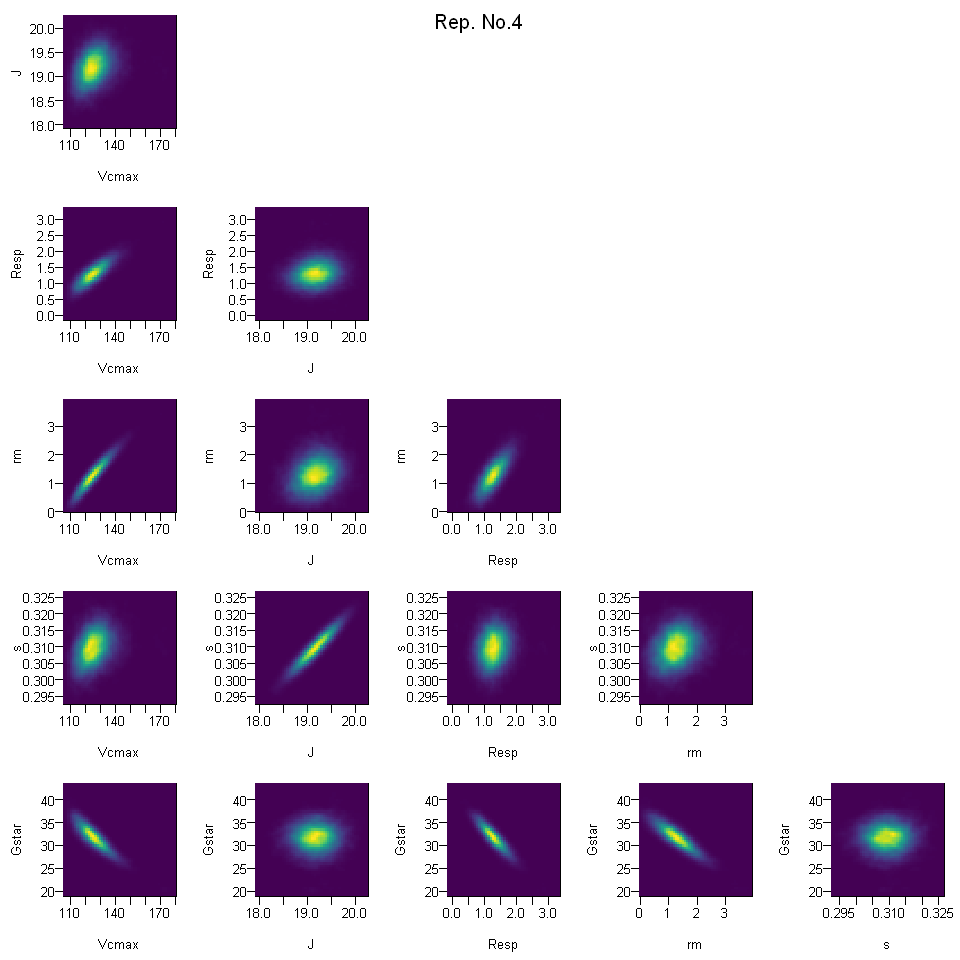

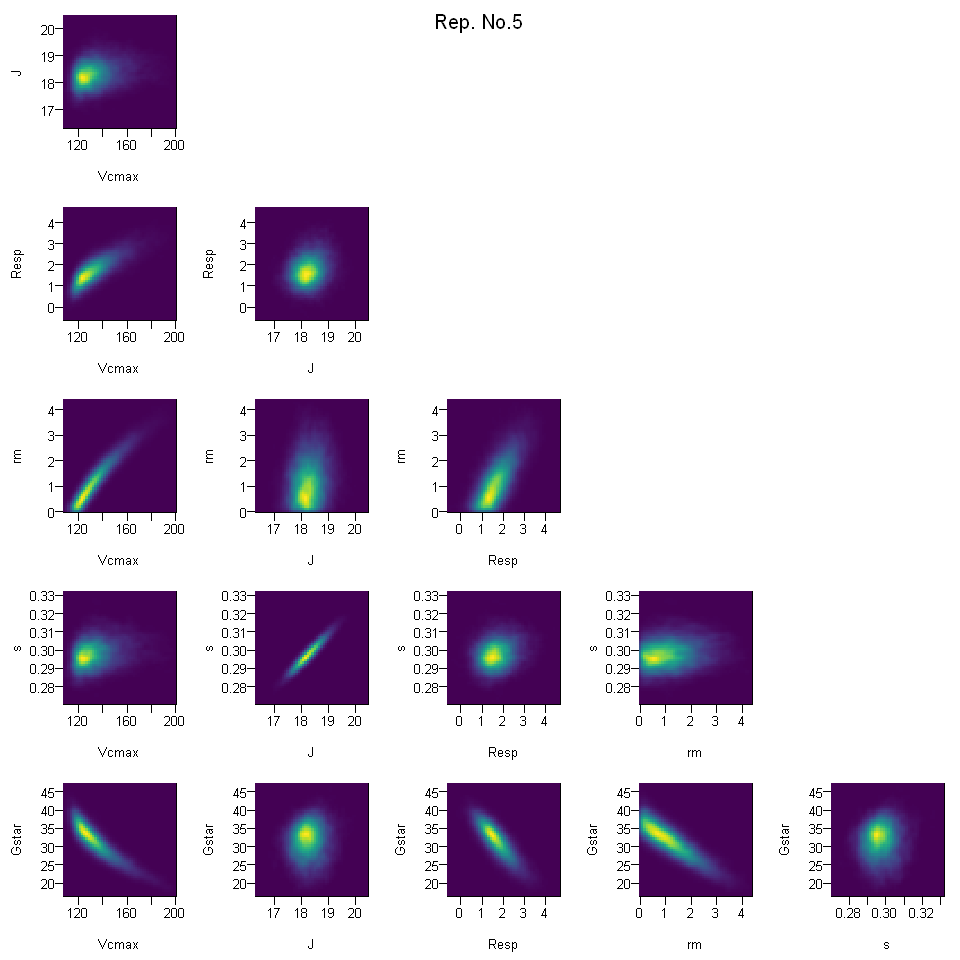

In [14]:
for (looprep2plot in seq(numRep)) {
    plot.new()
    varname2plot <- c('Vcmax','J','Resp','rm','s','Gstar')
    par(mfrow=c(length(varname2plot)-1,length(varname2plot)-1))
    options(repr.plot.width=8, repr.plot.height=8)
    for (tmpint1 in seq(length(varname2plot)-1)) {
        tmpvar1=varname2plot[tmpint1]
        tmpidx1 <- which(tmpvar1 == names(SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list))
        for (tmpint2 in seq(tmpint1+1,length(varname2plot))) {
            tmpvar2=varname2plot[tmpint2]
            tmpidx2 <- which(tmpvar2 == names(SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list))
            if (tmpvar1 != 'J') {
                xdata <- SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list[[tmpidx1]]
            }
            else {
                xdata <- SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list[[tmpidx1]][,4]
            }
            if (tmpvar2 != 'J') {
                ydata <- SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list[[tmpidx2]]
            }
            else {
                ydata <- SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list[[tmpidx2]][,4]
            }
            tmp.kde <- kde2d(xdata, ydata, n=50)
            #par(mfg=c(tmpint1, tmpint2-1))
            #par(mfg=c(length(varname2plot)-tmpint2+1, tmpint1))
            par(mfg=c(tmpint2-1, tmpint1), mar=c(4,4,1,1), mgp=c(2.5,0.5,0))
            image(tmp.kde,col=viridis(256),xlab=tmpvar1,ylab=tmpvar2,las=1); #contour(tmp.kde, add = T)
        }
    }
    mtext(paste("Rep. No.", looprep2plot, sep=""), side = 3, line = -2, outer = TRUE)
}

## 3.3 Plot predicted An-Ci and/or Y(II)-Ci curves based on posterior distribution

In [15]:
numsamples2plot <- 1000 #full size is 30000, but it will be very slow in rendering


In [16]:
cmap4 <- rainbow(length(tmpidxPPFD2))
tmpcmap4 <- col2rgb(cmap4)/1.5
cmap4darker<- rgb(t(tmpcmap4), maxColorValue=255)
cmap4transparent <- rainbow(length(tmpidxPPFD2), alpha=0.05)
for (looprep2plot in seq(numRep)) {
    #looprep2plot <- 1
    options(repr.plot.width = 8, repr.plot.height = 8)
    par(mfrow=c(2,2))
    
    tmpxrange1 <- range(unlist(obs.Ci)[which(obs.Q==max(PPFDdetected))])#Ci range under saturating light
    lineci1 <- seq(tmpxrange1[1], tmpxrange1[2], length.out=100)
    tmpxrange2 <- range(unlist(obs.Ci)[which(obs.Q!=max(PPFDdetected))])#Ci range under low light
    lineci2 <- seq(tmpxrange2[1], tmpxrange2[2], length.out=100)
    
    tmpidxPPFD1 <- which.max(PPFDdetected)
    samples.post1 <- list()
    tmprangeA1 <- list()
    tmprangeyii1 <- list()
    tmpidxPPFD2 <- which(PPFDdetected!=max(PPFDdetected))
    samples.post2 <- list()
    tmprangeA2 <- list()
    tmprangeyii2 <- list()
    
    for (looppost in seq(numsamples2plot)) {# plot all 30000 lines will be slow
        samples.post1[[looppost]] <- FunFvCBgmOPTAYII2ci(lineci1, 
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Vcmax[looppost],
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Km[looppost],
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Gstar[looppost],
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Resp[looppost],
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$rm[looppost],
                                                         max(PPFDdetected), 
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$J[looppost, tmpidxPPFD1], 
                                                         SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$s[looppost])
        tmprangeA1[[looppost]] <- range(samples.post1[[looppost]]$A)
        tmprangeyii1[[looppost]] <- range(samples.post1[[looppost]]$yii)
        for (looplightlevel in seq_along(tmpidxPPFD2)) {
            tmpidx2d <- looplightlevel+length(tmpidxPPFD2)*(looppost-1)
            samples.post2[[tmpidx2d]] <- FunFvCBgmOPTAYII2ci(lineci2, 
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Vcmax[looppost],
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Km[looppost],
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Gstar[looppost],
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$Resp[looppost],
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$rm[looppost],
                                                             PPFDdetected[tmpidxPPFD2[looplightlevel]], 
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$J[looppost, tmpidxPPFD2[looplightlevel]], 
                                                             SaveJAGSOneRep[[looprep2plot]]$BUGSoutput$sims.list$s[looppost])
            tmprangeA2[[tmpidx2d]] <- range(samples.post2[[looppost]]$A)
            tmprangeyii2[[tmpidx2d]] <- range(samples.post2[[looppost]]$yii)
        }
    }
    
    #A) plot A-Ci under saturating light
    par(mar=c(4,4,4,1))
    for (looppost in seq(numsamples2plot)) {
        if (looppost==1) {
            plot(lineci1, samples.post1[[looppost]]$A, col="gray", type="l",
                 xlim=range(lineci1), ylim=range(tmprangeA1),
                 xlab="Ci", ylab="An", las=1)
        } else {
            lines(lineci1, samples.post1[[looppost]]$A, col="gray")
        }
    }
    tmpCi=na.omit(unlist(obs.Ci[looprep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(obs.Q[looprep2plot,]))
    tmpA=na.omit(unlist(obs.A[looprep2plot,]))
    tmpyii=na.omit(unlist(obs.yii[looprep2plot,]))
    tmpidx1=which(tmpQ==max(PPFDdetected))
    points(tmpCi[tmpidx1],tmpA[tmpidx1],xlab="Ci",ylab="An",las=1)
    #B) plot Y(II)-Ci under saturating light
    par(mar=c(4,4,4,1))
    for (looppost in seq(numsamples2plot)) {
        if (looppost==1) {
            plot(lineci1, samples.post1[[looppost]]$yii, col="gray", type="l",
                 xlim=range(lineci1), ylim=range(tmprangeyii1),
                 xlab="Ci", ylab="Y(II)", las=1)
        } else {
            lines(lineci1, samples.post1[[looppost]]$yii, col="gray")
        }
    }
    points(tmpCi[tmpidx1],tmpyii[tmpidx1],xlab="Ci",ylab="An",las=1)
    #C) plot A-Ci under low lights
    par(mar=c(7,4,1,1))
    for (looppost in seq(numsamples2plot)) {
        for (looplightlevel in seq_along(tmpidxPPFD2)) {
            tmpidx2d <- looplightlevel+length(tmpidxPPFD2)*(looppost-1)
            if (looppost==1 && looplightlevel==1) {
                plot(lineci2, samples.post2[[tmpidx2d]]$A, col=cmap4transparent[looplightlevel], type="l",
                     xlim=range(lineci2), ylim=range(tmprangeA2),
                     xlab="Ci", ylab="An", las=1)
            } else {
                lines(lineci2, samples.post2[[tmpidx2d]]$A, col=cmap4transparent[looplightlevel])
            }
        }
    }
    tmpCi=na.omit(unlist(obs.Ci[looprep2plot,]))#compatible to replications with different pts
    tmpQ=na.omit(unlist(obs.Q[looprep2plot,]))
    tmpA=na.omit(unlist(obs.A[looprep2plot,]))
    tmpyii=na.omit(unlist(obs.yii[looprep2plot,]))
    for (looplightlevel in seq_along(tmpidxPPFD2)) {
        tmplowlight=PPFDdetected[tmpidxPPFD2[looplightlevel]]
        tmpidx2=which(tmpQ==tmplowlight)
        points(tmpCi[tmpidx2], tmpA[tmpidx2], pch=looplightlevel+14,
               col=cmap4darker[looplightlevel], las=1)
    }
    legend("topleft",legend = paste("rep.", looprep2plot, ": PPFD ",PPFDdetected[setdiff(seq_along(PPFDdetected),which.max(PPFDdetected))], sep=""), 
           col=cmap4darker, bty="n", box.lty=0, pch=seq(length(PPFDdetected)-1)+14,
           y.intersp=1, yjust=1)
    #D) plot Y(II)-Ci under low lights
    par(mar=c(7,4,1,1))
    for (looppost in seq(numsamples2plot)) {
        for (looplightlevel in seq_along(tmpidxPPFD2)) {
            tmpidx2d <- looplightlevel+length(tmpidxPPFD2)*(looppost-1)
            if (looppost==1 && looplightlevel==1) {
                plot(lineci2, samples.post2[[tmpidx2d]]$yii, col=cmap4transparent[looplightlevel], type="l",
                     xlim=range(lineci2), ylim=range(tmprangeyii2),
                     xlab="Ci", ylab="Y(II)", las=1)
            } else {
                lines(lineci2, samples.post2[[tmpidx2d]]$yii, col=cmap4transparent[looplightlevel])
            }
        }
    }
    for (looplightlevel in seq_along(tmpidxPPFD2)) {
        tmplowlight=PPFDdetected[tmpidxPPFD2[looplightlevel]]
        tmpidx2=which(tmpQ==tmplowlight)
        points(tmpCi[tmpidx2], tmpyii[tmpidx2], pch=looplightlevel+14,
               col=cmap4darker[looplightlevel],las=1)
    }
    title(paste("Replication No.",looprep2plot), outer=TRUE, line=-3)
}

ERROR: Error in rainbow(length(tmpidxPPFD2)): object 'tmpidxPPFD2' not found
